In [1]:
## load packages ##
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy as sc
from scipy import stats
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import csv
import pandas as pd
# pd.set_option("display.max_rows", None, "display.max_columns", None)

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.stats import kde

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
import time
import random

In [2]:
usecols=['Pax6','Sostdc1','YFP','Vgat','Tomato','Vglut2','Nptx2','Pdyn','Pitx2']

filenames=['AG09_C1_quant.xlsx',
           'AG09_C2_quant.xlsx',
           'AG10_A2_quant.xlsx',
           'AG11_C1_quant.xlsx',
           'AG11_C2_quant.xlsx'
          ]

directory="C:\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig3 HCR\\halo files"

In [3]:
## load each sheet from each file into a single dataframe
df_master=pd.DataFrame()
df_master2=pd.DataFrame()
for i,filename in enumerate(filenames):
    print "Loading file: ", filename
    df_temp=pd.concat(pd.read_excel(os.path.join(directory,filename),sheet_name=None,usecols=usecols, skiprows=[1]))
    df_master=df_master.append(df_temp)
    
    ## get columns corresponding to X/Y position ##
    df_temp2=pd.concat(pd.read_excel(os.path.join(directory,filename),sheet_name=None,usecols=[66,67,68,69], skiprows=[1]))
    df_master2=df_master2.append(df_temp2)
print "Total Cells: ", df_master.shape[0]

Loading file:  AG09_C1_quant.xlsx
Loading file:  AG09_C2_quant.xlsx
Loading file:  AG10_A2_quant.xlsx
Loading file:  AG11_C1_quant.xlsx
Loading file:  AG11_C2_quant.xlsx
Total Cells:  92866


In [4]:
## Define plotting functions ##
    
## plot percent cells expression each gene
def twobars_percent(df1,df2,genes,label1,label2,title=None):
    df1counts=np.nan*np.zeros((len(genes)))
    df2counts=np.nan*np.zeros((len(genes)))
    
    for i,gene in enumerate(genes):
        df1counts[i]=(float(sum(df1[gene]>0))/df1.shape[0])*100
        df2counts[i]=(float(sum(df2[gene]>0))/df2.shape[0])*100
    
    x=np.arange(len(genes))
    width=.65

    fig,ax=plt.subplots(1,1,figsize=(10,5))
    df1bars=ax.bar(x,df1counts,width=.2,label=label1,color='turquoise')
    df2bars=ax.bar(x+width/3,df2counts,width=.2,label=label2,color='magenta')

    maxval=np.ceil(np.amax([df1counts,df2counts]))

    ax.set_ylabel('% Cells',fontsize=14)
    ax.set_title('Compare '+str(label1)+' and '+str(label2)+' cells',fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(genes,fontsize=14)
    ax.set_yticks(arange(0,101,10))
    ax.set_yticklabels(arange(0,101,10),fontsize=14)
    ax.legend(fontsize=16)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=10)
#     autolabel(df1bars)## uncomment for labels on bars ##
#     autolabel(df2bars)
    fig.tight_layout()
    plt.savefig(title+'_'+label1+'_v_'+label2+'_percent_cells.pdf',dpi=300,format='pdf',bbox_inches='tight')
    plt.show()
    
    d=np.array(genes)
    savefile=np.vstack((d.T,df1counts,df2counts))
    np.savetxt('Percent_expression_'+title+'.csv',savefile,delimiter=',',fmt='%s')
    
    return df1counts,df2counts

## function to correlate two variables ##
def plot_corr2(hcrdata,seqdata,title,color='k'):
    fig,ax=plt.subplots(figsize=(5,5))
    sns.regplot(hcrdata,seqdata,fit_reg=True,scatter=True,ci=0,truncate=True,color=color)
    ax.set_xlabel('HCR',fontsize=14)
    ax.set_ylabel('Seq',fontsize=16)
    ax.set_title(title,fontsize=14)
    r,p=sc.stats.pearsonr(hcrdata,seqdata)
    ymin,ymax=ax.get_ylim()
    xmin,xmax=ax.get_xlim()
    xloc=(xmax-xmin)/2
    plt.xlim(0)
    plt.ylim(0)
    extratext= 'r = ', round(r,3), 'p = ', round(p,3)
    plt.text(xloc-(xloc/2), ymax-(ymax/15),extratext,fontsize=14)
    
## Function to plot correlation data between HCR and Seq data for both fluors together ##
def plot_corr4(hcrdata1,hcrdata2, seqdata1, seqdata2, title, colors=['turquoise','magenta'],combine=False,labels=True):
    fig,ax=plt.subplots(figsize=(5,5))
    
    genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2']
    
    if combine==False:
        print "Plotting fluorophores independently"
        sns.regplot(hcrdata1,seqdata1,fit_reg=True,scatter=True,ci=0,truncate=True,color=colors[0],scatter_kws={'s':100})
        sns.regplot(hcrdata2,seqdata2,fit_reg=True,scatter=True,ci=0,truncate=True,color=colors[1],scatter_kws={'s':100})
        ax.set_xlabel('HCR',fontsize=14)
        ax.set_ylabel('Seq',fontsize=16)
        ax.set_title(title,fontsize=14,pad=50)
        r1,p1=sc.stats.pearsonr(hcrdata1,seqdata1)
        r2,p2=sc.stats.pearsonr(hcrdata2,seqdata2)
        ymin,ymax=ax.get_ylim()
        xmin,xmax=ax.get_xlim()
        xloc=(xmax-xmin)/2
        plt.xlim(0)
        plt.ylim(0)
        extratext1= 'r = ', round(r1,3), 'p = ', round(p1,3)
        extratext2= 'r = ', round(r2,3), 'p = ', round(p2,3)
        plt.text(xloc-(xloc/2), ymax+(ymax/10),extratext1,fontsize=14,color=colors[0])
        plt.text(xloc-(xloc/2), ymax+(ymax/30),extratext2,fontsize=14,color=colors[1])
        
        print xmax,ymax
        
        for i,gene in enumerate(genes):
            plt.text(hcrdata1[i]-(xmax/50), seqdata1[i]-(ymax/50), gene, horizontalalignment='right', fontsize=10, color='black', weight='regular')
            plt.text(hcrdata2[i]-(xmax/50), seqdata2[i]-(ymax/50), gene, horizontalalignment='right', fontsize=10, color='black', weight='regular')
        plt.show()
        
    if combine==True:
        print "Plotting fluorophores together"
        hcrdata=list(hcrdata1)+list(hcrdata2)
        seqdata=list(seqdata1)+list(seqdata2)
        color_array=[]
        for i in range(len(hcrdata1)):
            color_array.append(colors[0])
        for i in range(len(hcrdata2)):
            color_array.append(colors[1])

        fig = sns.regplot(hcrdata,seqdata,fit_reg=True,scatter=True,ci=0,truncate=True,scatter_kws={"color": color_array, 's':100},line_kws={"color":'k'},)
        ax.set_xlabel('HCR',fontsize=14)
        ax.set_ylabel('Seq',fontsize=16)
        ax.set_title(title,fontsize=14,pad=30)
        r,p=sc.stats.pearsonr(hcrdata,seqdata)
        ymin,ymax=ax.get_ylim()
        xmin,xmax=ax.get_xlim()
        xloc=(xmax-xmin)/2
        plt.xlim(0)
        plt.ylim(0)
        extratext= 'r = ', round(r,3), 'p = ', round(p,5)
        plt.text(xloc-(xloc/2), ymax+(ymax/30),extratext,fontsize=14)
        plt.text(xmax+(xmax/20), ymax, 'YFP',fontsize=16,color=colors[0])
        plt.text(xmax+(xmax/20), ymax-(ymax/10), 'Tomato',fontsize=16,color=colors[1])
        
        genes=genes+genes
        if labels==True:
            for i,gene in enumerate(genes):
                 fig.text(hcrdata[i]-(xmax/50), seqdata[i]-(ymax/50), gene, horizontalalignment='right', fontsize=10, color='black', weight='regular')
                
        plt.savefig('Correlate HCR and SEQ data '+title+'.pdf',dpi=300,format='pdf',bbox_inches='tight')
        plt.show()
        
        d=np.array(genes)
        savefile=np.vstack((d.T,hcrdata,seqdata))
        np.savetxt('Correlate HCR and SEQ data '+title+'.csv',savefile,delimiter=',',fmt='%s')       
    
## plot YFP and TOM +gene spatial distribution ##
def make_jointplots(df1,df2,tag1,tag2,genes,title,bandwidth,copythresh):
#     colors=['turquoise','magenta']
    colors=['darkgreen','darkviolet']
    for gene in genes:
        def filterdf(df):
            df_temp=df[df[gene]>=copythresh]
            df_temp=df_temp[['Xcenter_norm','Ycenter_norm']]
            return df_temp
        df1_temp=filterdf(df1)
        df2_temp=filterdf(df2)
        df1_temp['Tag']=tag1
        df2_temp['Tag']=tag2       
        df=pd.concat((df1_temp,df2_temp))
        
        def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=1):
            def colored_scatter(x, y, c=None):
                def scatter(*args, **kwargs):
                    args = (x, y)
#                     if c is not None:
#                         kwargs['c'] = c
                    kwargs['alpha'] = scatter_alpha
#                     plt.scatter(c=color,*args, **kwargs)
                    sns.kdeplot(shade=True,shade_lowest=False,bw=bandwidth,color=color,*args,**kwargs)
                return scatter
            g = sns.JointGrid(
                x=col_x,
                y=col_y,
                data=df
            )
            color = None
            legends=[]
            for name, df_group in df.groupby(col_k):
                if name==tag1:
                    color=colors[0]
                else:
                    color=colors[1]
                legends.append(name)
                if k_is_color:
                    color=name
                g.plot_joint(
                    colored_scatter(df_group[col_x],df_group[col_y],color),
                )
                sns.distplot(
                    df_group[col_x].values,
                    ax=g.ax_marg_x,
                    color=color,
                    hist=False
                )
                sns.distplot(
                    df_group[col_y].values,
                    ax=g.ax_marg_y,
                    color=color,            
                    vertical=True,
                    hist=False
                )
            plt.title(gene,fontsize=16,pad=-20)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel('Medial '+ u'\u2194'+ ' Lateral',fontsize=16,labelpad=-20)
            plt.ylabel('Ventral '+ u'\u2194'+ ' Dorsal',fontsize=16,labelpad=-20)
            plt.xlim([0,1.05])
            plt.ylim([0,1.05])
            plt.gca().spines['left'].set_color('none')
            plt.gca().spines['bottom'].set_color('none')
            plt.legend(legends)
            plt.savefig('Overlay_distributions_'+title+'_'+gene+'_BW'+str(bandwidth)+'_CopyThresh'+str(copythresh)+'.pdf',dpi=300,format='pdf',bbox_inches='tight')
        multivariateGrid('Xcenter_norm', 'Ycenter_norm', 'Tag', df=df)
        
## plot YFP and TOM spatial distributions on same axis ##
def make_jointplots_single(df1,df2,tag1,tag2,title,bandwidth):
    colors=['turquoise','magenta']
    
    
    df1['Tag']=tag1
    df2['Tag']=tag2       
    df=pd.concat((df1,df2))
    
    
    def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=1):
        def colored_scatter(x, y, c=None):
            def scatter(*args, **kwargs):
                args = (x, y)
#                     if c is not None:
#                         kwargs['c'] = c
                kwargs['alpha'] = scatter_alpha
#                     plt.scatter(c=color,*args, **kwargs)
                sns.kdeplot(shade=True,shade_lowest=False,bw=bandwidth,color=color,*args,**kwargs)
            return scatter
        g = sns.JointGrid(
            x=col_x,
            y=col_y,
            data=df
        )
        color = None
        legends=[]
        for name, df_group in df.groupby(col_k):
            if name==tag1:
                color=colors[0]
            else:
                color=colors[1]
            legends.append(name)
            if k_is_color:
                color=name
            g.plot_joint(
                colored_scatter(df_group[col_x],df_group[col_y],color),
            )
            sns.distplot(
                df_group[col_x].values,
                ax=g.ax_marg_x,
                color=color,
                hist=False
            )
            sns.distplot(
                df_group[col_y].values,
                ax=g.ax_marg_y,
                color=color,            
                vertical=True,
                hist=False
            )
        plt.title(title,fontsize=16,pad=-20)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Medial '+ u'\u2194'+ ' Lateral',fontsize=16,labelpad=-20)
        plt.ylabel('Ventral '+ u'\u2194'+ ' Dorsal',fontsize=16,labelpad=-20)
        plt.xlim([0,1.05])
        plt.ylim([0,1.05])
        plt.gca().spines['left'].set_color('none')
        plt.gca().spines['bottom'].set_color('none')
        plt.legend(legends)
        plt.savefig('Overlay_'+tag1+'_and_'+tag2+'_distributions'+title+'_BW'+str(bandwidth)+'.pdf',dpi=300,format='pdf',bbox_inches='tight')
    multivariateGrid('Xcenter_norm', 'Ycenter_norm', 'Tag', df=df)
        
## plot xy distribution of genes ##
def plotxy(df,genes,title,bandwidth,copythresh,same_scale=True,cbar_on=True):
    ngenes=len(genes)
    fig, axes = plt.subplots(ncols=ngenes, nrows=1, figsize=(ngenes*5, 5),squeeze=False, gridspec_kw = {'wspace':0})
    for i,gene in enumerate(genes):
        df_temp=df[df[gene]>=copythresh]
        df_temp=df_temp[['Xcenter_norm','Ycenter_norm']]
        axes[0,i].set_title(gene,fontsize=16,pad=5)
        
        if same_scale==True:
            levels=np.arange(.1,4.1,.5)
            if i<ngenes-1:
                sns.kdeplot(data=df_temp,cmap='mako',shade=True,shade_lowest=False,bw=bandwidth,ax=axes[0,i],
                        common_norm=True,common_grid=True,levels=levels)
            else:
                sns.kdeplot(data=df_temp,cmap='mako',shade=True,shade_lowest=False,bw=bandwidth,ax=axes[0,i],
                        cbar=cbar_on,common_norm=True,
                        common_grid=True,levels=levels,
                        cbar_kws={'shrink':.75, 'label':'Relative density'})
        else:
            if i<ngenes-1:
                sns.kdeplot(data=df_temp,cmap='mako',shade=True,shade_lowest=False,bw=bandwidth,ax=axes[0,i],
                            common_norm=True,common_grid=True)
            else:
                sns.kdeplot(data=df_temp,cmap='mako',shade=True,shade_lowest=False,bw=bandwidth,ax=axes[0,i],
                            cbar=cbar_on,common_norm=True,
                            common_grid=True,
                            cbar_kws={'shrink':.75, 'label':'Relative density'})
            
        axes[0,i].spines["top"].set_visible(False)
        axes[0,i].spines["right"].set_visible(False)
        axes[0,i].spines["left"].set_visible(False)
        axes[0,i].spines["bottom"].set_visible(False)
        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])
        axes[0,i].set_xlabel('Medial '+ u'\u2194'+ ' Lateral',fontsize=14,labelpad=-20)
        axes[0,i].set_ylabel('Ventral '+ u'\u2194'+ ' Dorsal',fontsize=14,labelpad=-40)
        axes[0,i].set_ylim(ymin=-.15,ymax=1.15)
        axes[0,i].set_xlim(xmin=-.15,xmax=1.15)
        if cbar_on==True:
            axes[0,-1].figure.axes[-1].yaxis.label.set_size(20)
            axes[0,-1].figure.axes[-1].set_yticklabels([])
    plt.savefig('spatial_distribution_'+title+'BW'+str(bandwidth)+'CopyThresh'+str(copythresh)+'.pdf',dpi=300,format='pdf',bbox_inches='tight')
    plt.show()

In [5]:
## calculate centroids ##
df_master2.rename(columns={"Unnamed: 66": "Xmin", "Unnamed: 67":"Xmax","Unnamed: 68": "Ymin", "Unnamed: 69":"Ymax" },inplace=True)
df_master2['Xcenter']=(df_master2['Xmax']+df_master2['Xmin'])/2
df_master2['Ycenter']=(df_master2['Ymax']+df_master2['Ymin'])/2
df_master=pd.concat([df_master,df_master2],axis=1)

In [63]:
df=df_master.copy()

In [62]:
## Create output folder ##
os.chdir("C:\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig3 HCR")
try:
    os.mkdir('HCR_PYTHON_OUTPUT')
except OSError:
    print ("Creation of the directory %s failed" % 'HCR_PYTHON_OUTPUT')
else:
    print ("Successfully created the directory %s " % 'HCR_PYTHON_OUTPUT')
os.chdir('HCR_PYTHON_OUTPUT')

Successfully created the directory HCR_PYTHON_OUTPUT 


In [64]:
## define copy number filters for each probe
pax6filt=4    #4
sostdc1filt=6 #6
yfpfilt=3     #3
vgatfilt=5    #5
tomatofilt=3  #3
vglut2filt=5  #5
nptx2filt=10  #10
pdynfilt=2    #2
pitx2filt=6   #6

genes=['Pax6','Sostdc1','YFP','Vgat','Tomato','Vglut2','Nptx2','Pdyn','Pitx2']

### IMPORTANT ## 
use_counts=True ## if use_counts = True, use raw counts. Else use normalized/scaled data ## use True for svm
filter_counts = True ## filter counts based on copy number prior to normalizing?  ## use False for svm

In [65]:
## define metadata in columns from the excel sheet names
df=df_master.copy()

df.reset_index(inplace=True)
df.rename(columns={"level_0": "Sheet", "level_1":"Cell"},inplace=True)
df['Hemisphere']=df['Sheet'].str.strip().str[-1]
df['Mouse']=df['Sheet'].str.strip().str[:4]
df['Slice']=df['Sheet'].str.strip().str[-3]
df['Slide']=df['Sheet'].str.strip().str[-9:-7]
df['MouseSlideSlice']=df['Mouse']+df['Slide']+df['Slice']
df['Mouse+Hemisphere']=df['Mouse']+df['Hemisphere']
df=df.join(df.groupby('Mouse+Hemisphere')['Mouse+Hemisphere'].count(),on='Mouse+Hemisphere',rsuffix='_Total_Cells')

## Add AP coordinates for each slice ##
df.loc[df.MouseSlideSlice == 'AG09C11','AP coord']=-0.85
df.loc[df.MouseSlideSlice == 'AG09C12','AP coord']=-1.0
df.loc[df.MouseSlideSlice == 'AG09C13','AP coord']=-1.15
df.loc[df.MouseSlideSlice == 'AG09C14','AP coord']=-1.3

df.loc[df.MouseSlideSlice == 'AG09C16','AP coord']=-1.6
df.loc[df.MouseSlideSlice == 'AG09C21','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG09C22','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG09C23','AP coord']=-2.05
df.loc[df.MouseSlideSlice == 'AG09C24','AP coord']=-2.2

df.loc[df.MouseSlideSlice == 'AG10A21','AP coord']=-1.3
df.loc[df.MouseSlideSlice == 'AG10A22','AP coord']=-1.45
df.loc[df.MouseSlideSlice == 'AG10A23','AP coord']=-1.6
df.loc[df.MouseSlideSlice == 'AG10A24','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG10A25','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG10A26','AP coord']=-2.05

df.loc[df.MouseSlideSlice == 'AG11C11','AP coord']=-0.85
df.loc[df.MouseSlideSlice == 'AG11C12','AP coord']=-1.0
df.loc[df.MouseSlideSlice == 'AG11C13','AP coord']=-1.15
df.loc[df.MouseSlideSlice == 'AG11C14','AP coord']=-1.3
df.loc[df.MouseSlideSlice == 'AG11C15','AP coord']=-1.45
df.loc[df.MouseSlideSlice == 'AG11C16','AP coord']=-1.6

df.loc[df.MouseSlideSlice == 'AG11C21','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG11C22','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG11C23','AP coord']=-2.05
df.loc[df.MouseSlideSlice == 'AG11C24','AP coord']=-2.2
df.loc[df.MouseSlideSlice == 'AG11C25','AP coord']=-2.35
df.loc[df.MouseSlideSlice == 'AG11C26','AP coord']=-2.5

In [66]:
## get normalized xy coordinates for each cell ##

#Normalize by Max
df=df.join(df.groupby('MouseSlideSlice')['Xcenter'].max(),on='MouseSlideSlice',rsuffix='_max')
df=df.join(df.groupby('MouseSlideSlice')['Ycenter'].max(),on='MouseSlideSlice',rsuffix='_max')
df['Xcenter_norm'] = df['Xcenter']/df['Xcenter_max']
df['Ycenter_norm'] = df['Ycenter']/df['Ycenter_max']

## Use this for Max-Min normalization
# df=df.join(df.groupby('MouseSlideSlice')['Xcenter'].min(),on='MouseSlideSlice',rsuffix='_min')
# df=df.join(df.groupby('MouseSlideSlice')['Ycenter'].min(),on='MouseSlideSlice',rsuffix='_min')
# df['Xrange'] = df['Xcenter_max'] - df['Xcenter_min']
# df['Yrange'] = df['Ycenter_max'] - df['Ycenter_min']
# df['Xcenter_norm'] = df['Xcenter']/df['Xrange']
# df['Ycenter_norm'] = df['Ycenter']/df['Yrange']

# Flip left hemisphere data to match right hemisphere data (ie, High values = Lateral/Dorsal)
df.loc[df.Hemisphere == 'L','Xcenter_norm']= 1-df['Xcenter_norm']

In [67]:
## filter df by copy number and replace low values with 0
filters=[pax6filt,sostdc1filt,yfpfilt,vgatfilt,tomatofilt,vglut2filt,nptx2filt,pdynfilt,pitx2filt]
genes=['Pax6','Sostdc1','YFP','Vgat','Tomato','Vglut2','Nptx2','Pdyn','Pitx2']
def filterdf(dftemp,genes):
    dftemp=df.copy()
    for i,gene in enumerate(genes):
        a=np.array(dftemp[gene].values.tolist())
        dftemp[gene]=np.where(a<filters[i], 0, a).tolist()
    return dftemp
df_filt=filterdf(df,genes)
if filter_counts==True:
    print "Filtering data"
    df=df_filt
else:
    print "Using UNFILTERED data"
    df=df

Filtering data


In [68]:
## normalize and scale data ##
genes=['Pax6','Sostdc1','YFP','Vgat','Tomato','Vglut2','Nptx2','Pdyn','Pitx2']
def normscale(data,genes):
    data=data[genes]
    genes=data.columns
    dftemp=data.copy()
    x = dftemp.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled.T)
    
#     df_scaled = df_scaled*10000
    
#     df_scaled=df_scaled+1
#     df_scaled=np.log10(df_scaled)

#     df_scaled=np.log1p(df_scaled)
    
    df_scaled=df_scaled.T
    df_scaled.columns=genes
#     df_scaled = df_scaled[df_scaled.sum(axis=1) != 0]
    df_scaled.columns = [str(col) + '_scaled' for col in df_scaled.columns]
    return df_scaled
df_scaled = normscale(df,genes)
df = pd.concat([df,df_scaled],axis=1)

if use_counts==True:
    print "USING RAW COUNTS"
else:
    print "USING SCALED/TRANSFORMED COUNTS"
    for gene in genes:
        df[gene]=df[gene+'_scaled']

USING RAW COUNTS


In [69]:
yfpfilt=6  ## 6 or 8  norm: .2-.35
tomatofilt=4 ## 4 nor: .15-.3

In [70]:
## filter data by thresholds

# mask for YFP expression cells 
maskyfp=(df['Tomato']<=tomatofilt) & (df['YFP']>=yfpfilt) & (df['Tomato']<tomatofilt)
yfpdf=df[maskyfp]

# mask for Tomato expression cells 
masktom=(df['Tomato']>=tomatofilt) & (df['YFP']<=yfpfilt) & (df['YFP']<yfpfilt)
tomdf=df[masktom]

# mask for YFP and Tomato expression cells 
maskfluor=(df['Tomato']>tomatofilt) & (df['YFP']>yfpfilt)
fluordf=df[maskfluor]

def makefiltdf(gene,filt):
    mask=df[gene]>=filt
    tempdf=df[mask]
    return tempdf

pax6df=makefiltdf("Pax6",pax6filt)
sostdc1df=makefiltdf('Sostdc1',sostdc1filt)
vgatdf=makefiltdf('Vgat',vgatfilt)
vglut2df=makefiltdf('Vglut2',vglut2filt)
nptx2df=makefiltdf('Nptx2',nptx2filt)
pdyndf=makefiltdf('Pdyn',pdynfilt)
pitx2df=makefiltdf('Pitx2',pitx2filt)

#masks for Vglut/yfp and Vglut/tom
glutyfpmask=(df['Vglut2']>=vglut2filt) & (df['YFP']>=yfpfilt) & (df['Tomato']<tomatofilt)
glutyfpdf=df[glutyfpmask]

gluttommask=(df['Vglut2']>=vglut2filt) & (df['Tomato']>=tomatofilt) & (df['YFP']<yfpfilt)
gluttomdf=df[gluttommask]

#masks for Vgat/yfp and Vgat/tom
vgatyfpmask=(df['Vgat']>=vgatfilt) & (df['YFP']>=yfpfilt) & (df['Tomato']<tomatofilt)
vgatyfpdf=df[vgatyfpmask]

vgattommask=(df['Vgat']>=vgatfilt) & (df['Tomato']>=tomatofilt) & (df['YFP']<yfpfilt)
vgattomdf=df[vgattommask]

numyfp=yfpdf.shape[0]
numtom=tomdf.shape[0]
numboth=fluordf.shape[0]

yfpORtomdf=pd.concat([yfpdf,tomdf])

print "Number of YFP cells: ", numyfp
print "Number of Tomato cells: ", numtom

#save parameters to csv
params=['Cells before filtering: '+str(cellsbeforefilt),
        'Num YFP+ cells: '+str(numyfp),
        'Num Tom+ cells: '+str(numtom),
        'Num Both+ cells: '+str(numboth),
        'Pax6 filt: '+str(pax6filt),
       'Sostdc1 filt: '+str(sostdc1filt),
       'YFP filt: '+str(yfpfilt),
       'Vgat filt: '+str(vgatfilt),
       'Tomato filt: '+str(tomatofilt),
       'Vglut2 filt: '+str(vglut2filt),
       'Nptx2 filt: '+str(nptx2filt),
       'Pdyn filt: '+str(pdynfilt),
       'Pitx2 filt: '+str(pitx2filt)]
with open('Copy_Number_Filter_INFO.csv','wb') as myfile:
    out=csv.writer(myfile,delimiter=',',dialect='excel',quoting=csv.QUOTE_ALL)
    out.writerow(params)

Number of YFP cells:  816
Number of Tomato cells:  857


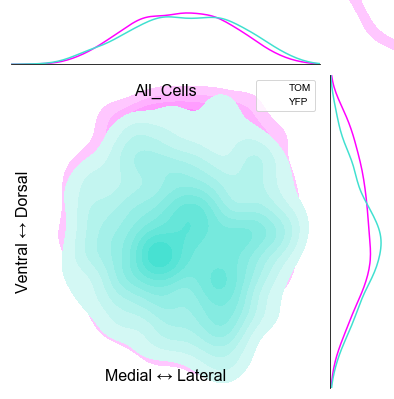

In [71]:
## Fig 3L: YFP and TOM spatial distributions        
make_jointplots_single(yfpdf,tomdf,tag1='YFP',tag2='TOM',title='All_Cells',bandwidth=0.05)

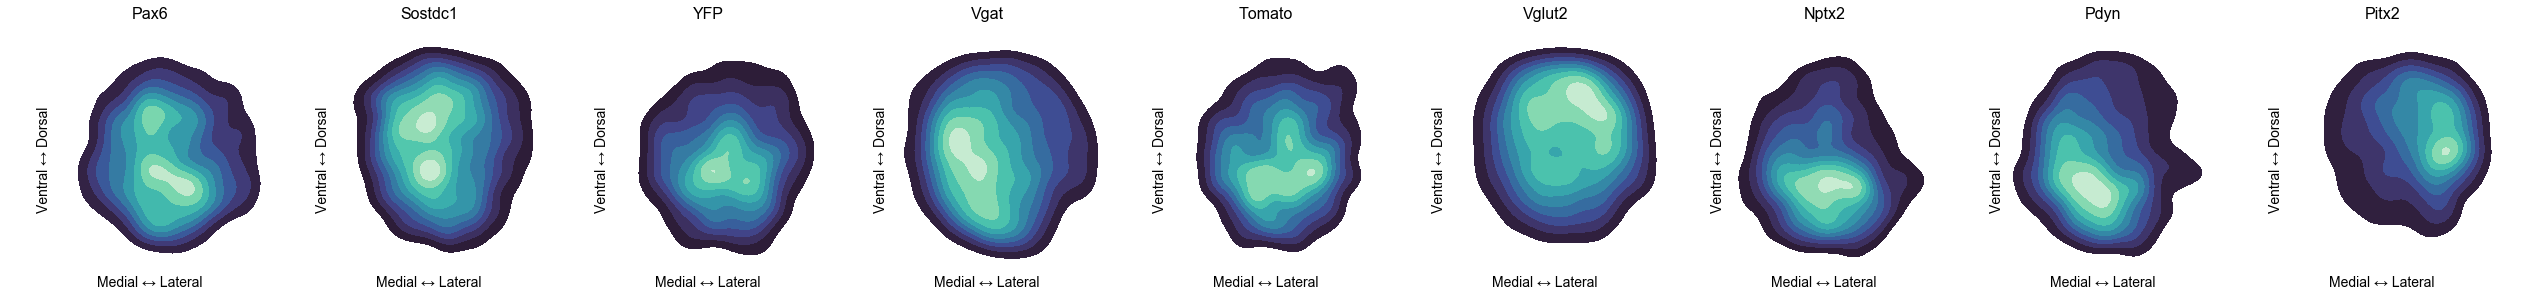

In [72]:
## Fig S2A: XY distribution of genes ##       
plotxy(df,genes=['Pax6','Sostdc1','YFP','Vgat','Tomato','Vglut2','Nptx2','Pdyn','Pitx2'],title='all_cells',bandwidth=0.05,copythresh=5,same_scale=False,cbar_on=False)


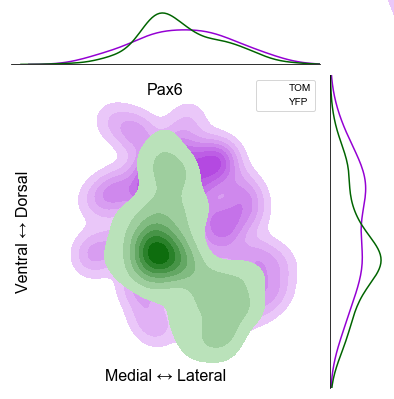

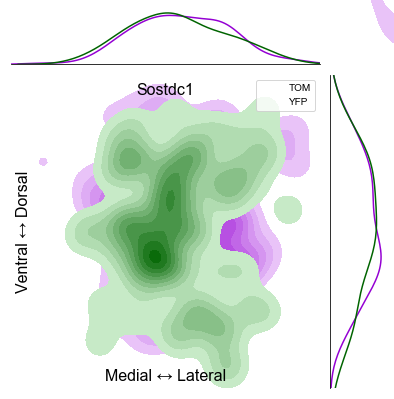

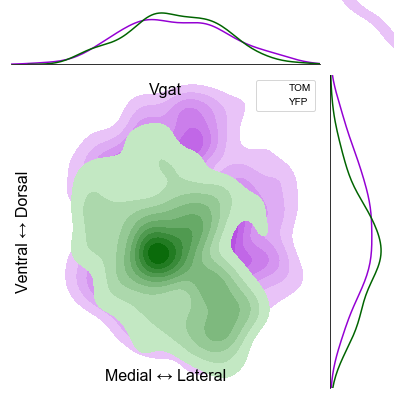

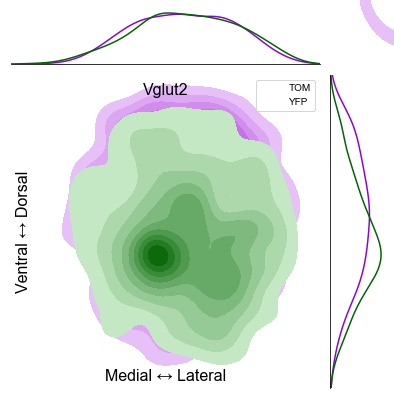

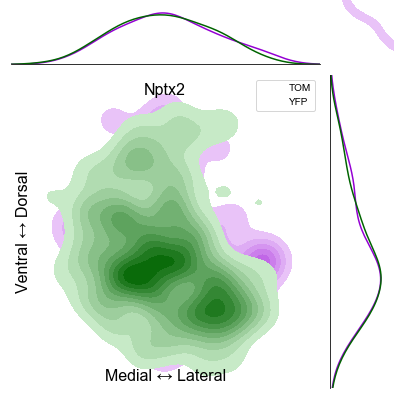

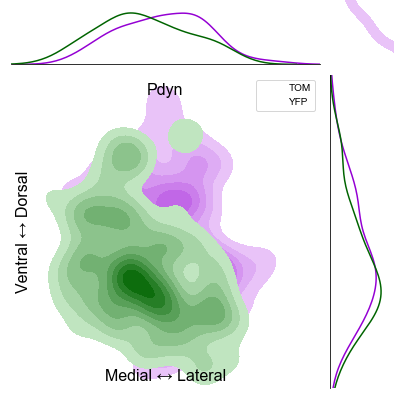

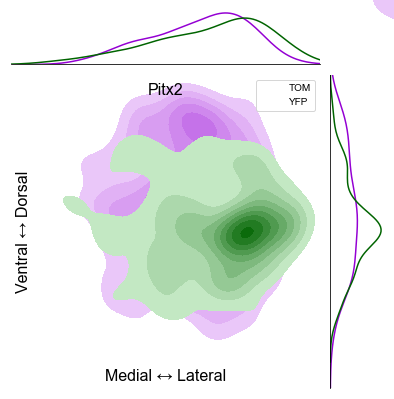

In [73]:
## Fig S2B: YFP and TOM +gene spatial distribution ##
make_jointplots(yfpdf,tomdf,tag1='YFP',tag2='TOM',genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'],title='YFP vs TOM',bandwidth=0.05,copythresh=5)

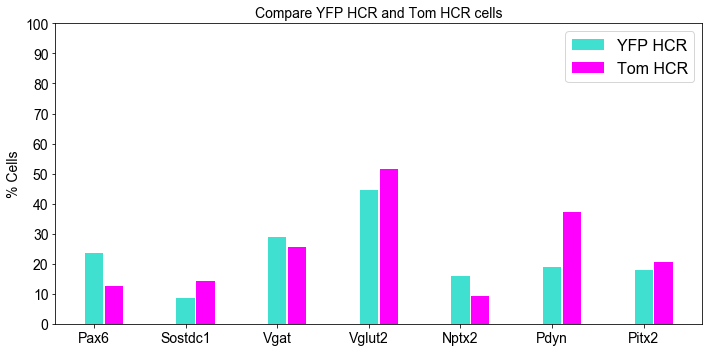

In [74]:
## Fig 3M: HCR bar graphs ##
genes=['Pax6','Sostdc1','YFP','Vgat','Tomato','Vglut2','Nptx2','Pdyn','Pitx2']

yfpdf_percent, tomdf_percent = twobars_percent(yfpdf,tomdf,['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'],'YFP HCR','Tom HCR','Compare_projections_HCR')

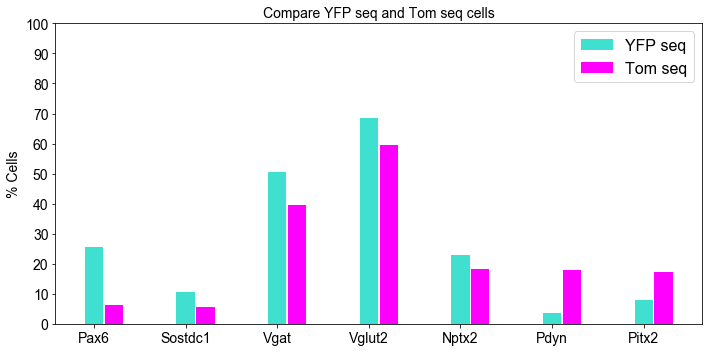

In [75]:
## Fig 3N: Seq bar graphs ##
## load Single cell data from previously saved csv files and plot bars ##
seqdir="C:\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig2 seq\\R output" ## location of files

seqgenes=['Pax6','Sostdc1','eyfp','Slc32a1','tdtomato','Slc17a6','Nptx2','Pdyn','Pitx2']

def openseqfile(seqdir,seqfile,seqgenes):
    tempdf=pd.read_csv(os.path.join(seqdir,seqfile))
    tempdf=tempdf[seqgenes]
    tempdf.rename(columns={"eyfp": "YFP", "Slc32a1":"Vgat", "tdtomato": "Tomato","Slc17a6":"Vglut2"},inplace=True)
    tempdf['Hemisphere']='seq'
    tempdf['Mouse']='seq'
    tempdf['Slice']='seq'
    tempdf['Slide']='seq'
    tempdf['MouseSlideSlice']='seq'
    tempdf['Mouse+Hemisphere']='seq'
    return tempdf 
tomseqdf=openseqfile(seqdir,'Seurat_SCT_Tomato_Cells_subset_genes_UPDATED210130.csv',seqgenes)
yfpseqdf=openseqfile(seqdir,'Seurat_SCT_YFP_Cells_subset_genes_UPDATED210130.csv',seqgenes)


## plot bar graphs from sequencing data ##
yfpseqdf_percent, tomseqdf_percent = twobars_percent(yfpseqdf,tomseqdf,['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'],'YFP seq','Tom seq','Compare_projections_seq')

Plotting fluorophores together


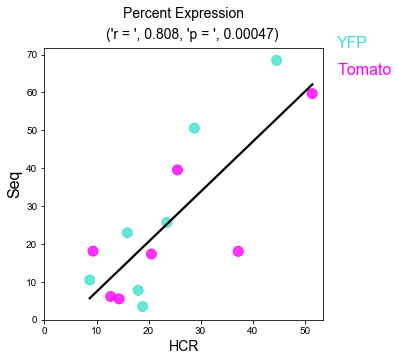

In [76]:
## Fig 3O:  correlations between HCR and SEQ data##
plot_corr4(yfpdf_percent,tomdf_percent,yfpseqdf_percent,tomseqdf_percent, 'Percent Expression',colors=['turquoise','magenta'],combine=True,labels=False)

In [77]:
## Format HCR df to be used with SVM decoding of yfp/mcherry tag from other gene expression ##
df=df_master.copy()

use_counts=True ## if use_counts = True, use raw counts. Else use normalized/scaled data ## use True for svm
filter_counts = False ## filter counts based on copy number prior to normalizing?  ## use False for svm

## define metadata in columns from the excel sheet names
df=df_master.copy()

df.reset_index(inplace=True)
df.rename(columns={"level_0": "Sheet", "level_1":"Cell"},inplace=True)
df['Hemisphere']=df['Sheet'].str.strip().str[-1]
df['Mouse']=df['Sheet'].str.strip().str[:4]
df['Slice']=df['Sheet'].str.strip().str[-3]
df['Slide']=df['Sheet'].str.strip().str[-9:-7]
df['MouseSlideSlice']=df['Mouse']+df['Slide']+df['Slice']
df['Mouse+Hemisphere']=df['Mouse']+df['Hemisphere']
df=df.join(df.groupby('Mouse+Hemisphere')['Mouse+Hemisphere'].count(),on='Mouse+Hemisphere',rsuffix='_Total_Cells')

## Add AP coordinates for each slice ##
df.loc[df.MouseSlideSlice == 'AG09C11','AP coord']=-0.85
df.loc[df.MouseSlideSlice == 'AG09C12','AP coord']=-1.0
df.loc[df.MouseSlideSlice == 'AG09C13','AP coord']=-1.15
df.loc[df.MouseSlideSlice == 'AG09C14','AP coord']=-1.3

df.loc[df.MouseSlideSlice == 'AG09C16','AP coord']=-1.6
df.loc[df.MouseSlideSlice == 'AG09C21','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG09C22','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG09C23','AP coord']=-2.05
df.loc[df.MouseSlideSlice == 'AG09C24','AP coord']=-2.2

df.loc[df.MouseSlideSlice == 'AG10A21','AP coord']=-1.3
df.loc[df.MouseSlideSlice == 'AG10A22','AP coord']=-1.45
df.loc[df.MouseSlideSlice == 'AG10A23','AP coord']=-1.6
df.loc[df.MouseSlideSlice == 'AG10A24','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG10A25','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG10A26','AP coord']=-2.05

df.loc[df.MouseSlideSlice == 'AG11C11','AP coord']=-0.85
df.loc[df.MouseSlideSlice == 'AG11C12','AP coord']=-1.0
df.loc[df.MouseSlideSlice == 'AG11C13','AP coord']=-1.15
df.loc[df.MouseSlideSlice == 'AG11C14','AP coord']=-1.3
df.loc[df.MouseSlideSlice == 'AG11C15','AP coord']=-1.45
df.loc[df.MouseSlideSlice == 'AG11C16','AP coord']=-1.6

df.loc[df.MouseSlideSlice == 'AG11C21','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG11C22','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG11C23','AP coord']=-2.05
df.loc[df.MouseSlideSlice == 'AG11C24','AP coord']=-2.2
df.loc[df.MouseSlideSlice == 'AG11C25','AP coord']=-2.35
df.loc[df.MouseSlideSlice == 'AG11C26','AP coord']=-2.5

## get normalized xy coordinates for each cell ##
#Normalize by Max
df=df.join(df.groupby('MouseSlideSlice')['Xcenter'].max(),on='MouseSlideSlice',rsuffix='_max')
df=df.join(df.groupby('MouseSlideSlice')['Ycenter'].max(),on='MouseSlideSlice',rsuffix='_max')
df['Xcenter_norm'] = df['Xcenter']/df['Xcenter_max']
df['Ycenter_norm'] = df['Ycenter']/df['Ycenter_max']

# Flip left hemisphere data to match right hemisphere data (ie, High values = Lateral/Dorsal)
df.loc[df.Hemisphere == 'L','Xcenter_norm']= 1-df['Xcenter_norm']

## create dataframe for SVM ##
df['Fluor Tag']='None'
df.loc[(df.YFP >= yfpfilt) & (df.Tomato < tomatofilt),'Fluor Tag']= 'YFP'
df.loc[(df.Tomato >= tomatofilt) & (df.YFP < yfpfilt), 'Fluor Tag']='Tomato'
# df.loc[(df.YFP > yfpfilt) & (df.Tomato > tomatofilt), 'Fluor Tag']='Both'

print "YFP cells: ", df[df['Fluor Tag']=='YFP'].shape[0]
print "Tomato cells: ",df[df['Fluor Tag']=='Tomato'].shape[0]

yfptemp =  df[df['Fluor Tag']=='YFP']
tomtemp =  df[df['Fluor Tag']=='Tomato']
df.to_csv('HCR_data.csv',sep=',')
df_for_svm = pd.concat([yfptemp,tomtemp],axis=0)

YFP cells:  816
Tomato cells:  857


#  Stop! Use R/Seurat to generate LogFC data

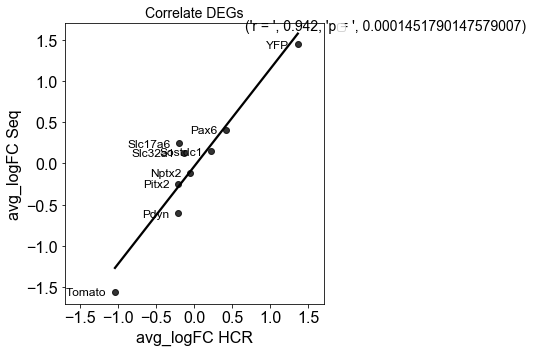

In [78]:
## Fig 3P: correlate HCR and Seq logFC ##
seqdir="C:\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig2 seq\\R output"
hcrdir="C:\\Users\\rossiadmin\\Dropbox (Stuber Lab)\\Mark\\LHA projection paper\\Data\\Fig3 HCR"
degfile='YFPvTOM_DEGs_ALL_UPDATED210130.csv' ## Generated by Seurat 
hcr_degfile = 'HRC_seurat_deg_output.csv'

seqdeg=pd.read_csv(os.path.join(seqdir,degfile))
HCRdeg=pd.read_csv(os.path.join(hcrdir,hcr_degfile))

seqdeg = seqdeg.replace(to_replace=['eyfp','tdtomato'],value=['YFP','Tomato']) ## to maintain consistency between datasets
HCRdeg = HCRdeg.replace(to_replace=['Vglut2','Vgat'],value=['Slc17a6','Slc32a1']) ## to maintain consistency between datasets

p_thresh=1e-2 ## significance threshold for determining colors on plot
degs_of_interest=['Pax6','Sostdc1','YFP','Slc32a1','Tomato','Slc17a6','Nptx2','Pdyn','Pitx2']
# degs_of_interest=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2']
## List of genes to label on final plot used for plotting labels
feature_use='avg_logFC' #'avg_logFC' or 'diff_pct'

seqdeg['-log10p']=-log10(seqdeg['p_val_adj'])
seqdeg['sig']= 'not sig'
seqdeg.loc[seqdeg.p_val_adj < p_thresh, 'sig']='sig'
seqdeg.loc[seqdeg.p_val_adj < p_thresh, 'label']=seqdeg['Unnamed: 0']
seqdeg['diff_pct']=seqdeg['pct.1']-seqdeg['pct.2']
seqdeg['label2']=0

HCRdeg['-log10p']=-log10(HCRdeg['p_val_adj'])
HCRdeg['sig']= 'not sig'
HCRdeg.loc[HCRdeg.p_val_adj < p_thresh, 'sig']='sig'
HCRdeg.loc[HCRdeg.p_val_adj < p_thresh, 'label']=HCRdeg['Unnamed: 0']
HCRdeg['diff_pct']=HCRdeg['pct.1']-HCRdeg['pct.2']
HCRdeg['label2']=0

for deg in degs_of_interest:
    seqdeg.loc[seqdeg['Unnamed: 0']==deg,'label2']=deg
    seqdeg.loc[seqdeg['Unnamed: 0']==deg,'sig']='interest' 
    
    HCRdeg.loc[HCRdeg['Unnamed: 0']==deg,'label2']=deg
    HCRdeg.loc[HCRdeg['Unnamed: 0']==deg,'sig']='interest' 

seqdeg=seqdeg[seqdeg['sig']=='interest']
HCRdeg=HCRdeg[HCRdeg['sig']=='interest']

tosave=np.nan*np.zeros((len(degs_of_interest),2))
tosave[:,0]=seqdeg['avg_logFC']
tosave[:,1]=HCRdeg['avg_logFC']
np.savetxt('Correlate_logFC_SEQvHCR.csv',tosave,delimiter=',')

fig,ax=plt.subplots(figsize=(5,5))
sns.regplot(x=HCRdeg[feature_use],y=seqdeg[feature_use],fit_reg=True,scatter=True,ci=0,truncate=True,color='black')
ax.set_xlabel('HCR',fontsize=14)
ax.set_ylabel('Seq',fontsize=16)
ax.set_title('Correlate DEGs',fontsize=14)
r,p=sc.stats.pearsonr(HCRdeg[feature_use],seqdeg[feature_use])
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
xloc=(xmax-xmin)/2
plt.xlim(-1.7,1.7)
plt.ylim(-1.7,1.7)
extratext= 'r = ', round(r,3), 'p = ', round(p,30)
plt.text(xloc-(xloc/2), ymax-(ymax/15),extratext,fontsize=14)

degs=seqdeg['label2'].values.tolist() #change to 'label' to plot labels for all sig genes. label2 for only degs of interest
xloc=HCRdeg[feature_use].values.tolist()
yloc=seqdeg[feature_use].values.tolist()

ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(feature_use+' HCR',fontsize=16)
plt.ylabel(feature_use+' Seq',fontsize=16)

for i,deg in enumerate(degs):
    if deg != 0:
        plt.text(xloc[i]-(xmax/15), yloc[i]-(ymax/40), deg, horizontalalignment='right', fontsize=12, color='black', weight='regular')
#         plt.text(xloc[i], yloc[i], deg, horizontalalignment='right', fontsize=12, color='black', weight='regular')
fig.tight_layout()
plt.savefig('Correlate_seq_and_HCR_DEGs_YFPvTOM.pdf',dpi=300,format='pdf',bbox_inches='tight')
plt.show()


In [48]:
## Load SEQ data to use for SVM classification ##
## Format HCR df to be used with SVM decoding of yfp/mcherry tag from other gene expression ##
df=df_master.copy()

use_counts=True ## if use_counts = True, use raw counts. Else use normalized/scaled data ## use True for svm
filter_counts = False ## filter counts based on copy number prior to normalizing?  ## use False for svm

## define metadata in columns from the excel sheet names
df=df_master.copy()

df.reset_index(inplace=True)
df.rename(columns={"level_0": "Sheet", "level_1":"Cell"},inplace=True)
df['Hemisphere']=df['Sheet'].str.strip().str[-1]
df['Mouse']=df['Sheet'].str.strip().str[:4]
df['Slice']=df['Sheet'].str.strip().str[-3]
df['Slide']=df['Sheet'].str.strip().str[-9:-7]
df['MouseSlideSlice']=df['Mouse']+df['Slide']+df['Slice']
df['Mouse+Hemisphere']=df['Mouse']+df['Hemisphere']
df=df.join(df.groupby('Mouse+Hemisphere')['Mouse+Hemisphere'].count(),on='Mouse+Hemisphere',rsuffix='_Total_Cells')

## Add AP coordinates for each slice ##
df.loc[df.MouseSlideSlice == 'AG09C11','AP coord']=-0.85
df.loc[df.MouseSlideSlice == 'AG09C12','AP coord']=-1.0
df.loc[df.MouseSlideSlice == 'AG09C13','AP coord']=-1.15
df.loc[df.MouseSlideSlice == 'AG09C14','AP coord']=-1.3

df.loc[df.MouseSlideSlice == 'AG09C16','AP coord']=-1.6
df.loc[df.MouseSlideSlice == 'AG09C21','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG09C22','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG09C23','AP coord']=-2.05
df.loc[df.MouseSlideSlice == 'AG09C24','AP coord']=-2.2

df.loc[df.MouseSlideSlice == 'AG10A21','AP coord']=-1.3
df.loc[df.MouseSlideSlice == 'AG10A22','AP coord']=-1.45
df.loc[df.MouseSlideSlice == 'AG10A23','AP coord']=-1.6
df.loc[df.MouseSlideSlice == 'AG10A24','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG10A25','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG10A26','AP coord']=-2.05

df.loc[df.MouseSlideSlice == 'AG11C11','AP coord']=-0.85
df.loc[df.MouseSlideSlice == 'AG11C12','AP coord']=-1.0
df.loc[df.MouseSlideSlice == 'AG11C13','AP coord']=-1.15
df.loc[df.MouseSlideSlice == 'AG11C14','AP coord']=-1.3
df.loc[df.MouseSlideSlice == 'AG11C15','AP coord']=-1.45
df.loc[df.MouseSlideSlice == 'AG11C16','AP coord']=-1.6

df.loc[df.MouseSlideSlice == 'AG11C21','AP coord']=-1.75
df.loc[df.MouseSlideSlice == 'AG11C22','AP coord']=-1.9
df.loc[df.MouseSlideSlice == 'AG11C23','AP coord']=-2.05
df.loc[df.MouseSlideSlice == 'AG11C24','AP coord']=-2.2
df.loc[df.MouseSlideSlice == 'AG11C25','AP coord']=-2.35
df.loc[df.MouseSlideSlice == 'AG11C26','AP coord']=-2.5

## get normalized xy coordinates for each cell ##
#Normalize by Max
df=df.join(df.groupby('MouseSlideSlice')['Xcenter'].max(),on='MouseSlideSlice',rsuffix='_max')
df=df.join(df.groupby('MouseSlideSlice')['Ycenter'].max(),on='MouseSlideSlice',rsuffix='_max')
df['Xcenter_norm'] = df['Xcenter']/df['Xcenter_max']
df['Ycenter_norm'] = df['Ycenter']/df['Ycenter_max']

# Flip left hemisphere data to match right hemisphere data (ie, High values = Lateral/Dorsal)
df.loc[df.Hemisphere == 'L','Xcenter_norm']= 1-df['Xcenter_norm']

## create dataframe for SVM ##
df['Fluor Tag']='None'
df.loc[(df.YFP >= yfpfilt) & (df.Tomato < tomatofilt),'Fluor Tag']= 'YFP'
df.loc[(df.Tomato >= tomatofilt) & (df.YFP < yfpfilt), 'Fluor Tag']='Tomato'
# df.loc[(df.YFP > yfpfilt) & (df.Tomato > tomatofilt), 'Fluor Tag']='Both'

yfptemp =  df[df['Fluor Tag']=='YFP']
tomtemp =  df[df['Fluor Tag']=='Tomato']
df.to_csv('HCR_data.csv',sep=',')
df_for_svm = pd.concat([yfptemp,tomtemp],axis=0)




seqdir="C:\\Users\\rossiadmin\\Desktop\\seq" ## location of files
seqdata = 'Seurat_YFP_and_Tomato_data_all_DEGs_UPDATED210430.csv'
genes=['Pax6','Sostdc1','eyfp','Slc32a1','tdtomato','Slc17a6','Nptx2','Pdyn','Pitx2']
seqdfsvm=pd.read_csv(os.path.join(seqdir,seqdata),index_col=0)
use_raw_counts = True

## subset genes and add 'Fluor Tag' for decoding ##
seqdfsvm=seqdfsvm[genes]
seqdfsvm.loc[seqdfsvm.eyfp > 0,'Fluor Tag']='YFP'
seqdfsvm.loc[seqdfsvm.tdtomato > 0,'Fluor Tag']='Tomato'

## if you choose to use raw counts, apply expm1 transform to un-transform the seq data ##
if use_raw_counts==True:
    print 'Un-transforming seq data'
    for gene in genes:
        temp=seqdfsvm[gene]
        temp=np.expm1(temp)
        seqdfsvm[gene]=temp

Un-transforming seq data


In [33]:
## SVM functions ##

## SVM function with modification to use an equal number of cells from each group ##
def HCR_SVM_equalize_ns(df_orig,genes,iterations,test_data,title='TEST'):
    parameters = [{'C': [.01,.1,1,10,100], 'kernel': ['linear']},
                  {'C': [.01,.1,.8,.9,1,5,10,100,], 'gamma': [.01,.1,1,5,10,15,20,100], 'kernel': ['rbf']}]  
    pred_score=np.nan*np.zeros((iterations))
    rand_score=np.nan*np.zeros((iterations))
    
    for i in range(iterations):
        df=df_orig.copy()
        df=pd.DataFrame(df)
        nyfp =  df.loc[df['Fluor Tag']=='YFP'].shape[0]
        ntom =  df.loc[df['Fluor Tag']=='Tomato'].shape[0]
        tempyfpdf = df.loc[df['Fluor Tag']=='YFP']
        ## take random sample of nyfp cells to use for analysis ##
        temptomdf = df.loc[df['Fluor Tag']=='Tomato'].sample(n = nyfp,axis=0)
        df=pd.concat([tempyfpdf,temptomdf])
        
        #normalize columns (except for 'Fluor Tag' column)##
        df_norm=df[genes]
        df_predict=df['Fluor Tag']
        df_norm=pd.DataFrame(preprocessing.scale(df_norm))

        ## use MaxAbsScaler to preserve sparse matrix
        x = preprocessing.MaxAbsScaler()
        df_norm = pd.DataFrame(x.fit_transform(df_norm))
        df_predict.reset_index(drop=True, inplace=True)
        df_norm.reset_index(drop=True, inplace=True)
        df=pd.concat([df_norm,df_predict],axis=1)
        df=df.dropna()
        headers=genes+['Fluor Tag']
        df.columns=headers
    
        print '\nRun #: ', i+1
        ## if splits result in insufficient data to classify, skip run and move on ##
        try:
            ##randomly subset df into test and train sets
            msk = np.random.rand(len(df))>test_data
            train = df[msk]
            ##use gridsearch to select optimal parameters for each run
            clf = GridSearchCV(SVC(), parameters,cv=10,n_jobs=-1,iid=False)
            train_labels=train['Fluor Tag'].values
            c=train_labels.shape
            train_labels=train_labels.reshape(c,)
            clf.fit(train[genes], train_labels)
            print 'prediction accuracy = ', clf.best_score_
            print clf.best_params_
            pred_score[i]=(clf.best_score_)*100
            ##random array of 1s and 0s for testing classifier
            rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
            clf.fit(train[genes], rand_group[0])
            print 'shuffled accuracy = ', clf.best_score_
            rand_score[i]=(clf.best_score_)*100
        except Exception:
            pass
        
    plt.figure(figsize=(5,5))
    ax=plt.subplot(111)
    n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score))
    Xs = np.sort(pred_score)
    plt.step(Xs,n,color='g',label='Model prediction',alpha=0.7,linewidth=2)
    n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score))
    Xs2= np.sort(rand_score)
    plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)
    plt.xlabel('Decoding accuracy %',fontsize=14)
    plt.ylabel('Proportion of runs',fontsize=14)
    plt.legend(fontsize=14,loc=2)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    plt.savefig('SVM_'+title+'_prediction_accuracy_CDF_'+str(iterations)+str('iter_')+str(test_data)+'test_proportion_'+timestr+'.pdf')
    np.savetxt('SVM_'+title+'_MODEL_prediction_accuracy_'+str(iterations)+str('iter_')+str(test_data)+'test_proportion_'+timestr+'.csv',pred_score,delimiter=',')
    np.savetxt('SVM_'+title+'_RANDOM_prediction_accuracy_'+str(iterations)+str('iter_')+str(test_data)+'test_proportion_'+timestr+'.csv',rand_score,delimiter=',')
    plt.show()
    
    print "mean decoding accuracy = ", np.nanmean(pred_score)
    print "mean RANDOM decoding accuracy = ",np.nanmean(rand_score)
#     return pred_score,rand_score

## SVM function with modification to use an equal number of cells from each group and LEAVE N genes out ##
def HCR_SVM_equalize_ns_leaveNout(df_orig,genes,iterations,test_data,title='TEST',n=0):
    parameters = [{'C': [.01,.1,1,10,100], 'kernel': ['linear']},
                  {'C': [.01,.1,.8,.9,1,5,10,100,], 'gamma': [.01,.1,1,5,10,15,20,100], 'kernel': ['rbf']}]  
    pred_score=np.nan*np.zeros((iterations))
    rand_score=np.nan*np.zeros((iterations))
    
    for i in range(iterations):
        
        ## Drop n genes out of list and run classifier ##
        tempgenes=genes[:]
        for a in range(n):
            rand_n=random.randrange(len(tempgenes))
            tempgenes.pop(rand_n)
        
        df=df_orig.copy()
        df=pd.DataFrame(df)
        nyfp =  df.loc[df['Fluor Tag']=='YFP'].shape[0]
        ntom =  df.loc[df['Fluor Tag']=='Tomato'].shape[0]
        tempyfpdf = df.loc[df['Fluor Tag']=='YFP']
        ## take random sample of nyfp cells to use for analysis ##
        temptomdf = df.loc[df['Fluor Tag']=='Tomato'].sample(n = nyfp,axis=0)
        df=pd.concat([tempyfpdf,temptomdf])
        
        #normalize columns (except for 'Fluor Tag' column)##
        df_norm=df[tempgenes]
        df_predict=df['Fluor Tag']
        df_norm=pd.DataFrame(preprocessing.scale(df_norm))

        ## use MaxAbsScaler to preserve sparse matrix
        x = preprocessing.MaxAbsScaler()
        df_norm = pd.DataFrame(x.fit_transform(df_norm))
        df_predict.reset_index(drop=True, inplace=True)
        df_norm.reset_index(drop=True, inplace=True)
        df=pd.concat([df_norm,df_predict],axis=1)
        df=df.dropna()
        headers=tempgenes+['Fluor Tag']
        df.columns=headers
    
        print '\nRun #: ', i+1
        ## if splits result in insufficient data to classify, skip run and move on ##
        try:
            ##randomly subset df into test and train sets
            msk = np.random.rand(len(df))>test_data
            train = df[msk]
            ##use gridsearch to select optimal parameters for each run
            clf = GridSearchCV(SVC(), parameters,cv=10,n_jobs=-1,iid=False)
            train_labels=train['Fluor Tag'].values
            c=train_labels.shape
            train_labels=train_labels.reshape(c,)
            clf.fit(train[tempgenes], train_labels)
            print 'prediction accuracy = ', clf.best_score_
            print clf.best_params_
            pred_score[i]=(clf.best_score_)*100
            ##random array of 1s and 0s for testing classifier
            rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
            clf.fit(train[tempgenes], rand_group[0])
            print 'shuffled accuracy = ', clf.best_score_
            rand_score[i]=(clf.best_score_)*100
        except Exception:
            pass
        
    plt.figure(figsize=(5,5))
    ax=plt.subplot(111)
    n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score))
    Xs = np.sort(pred_score)
    plt.step(Xs,n,color='g',label='Model prediction',alpha=0.7,linewidth=2)
    n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score))
    Xs2= np.sort(rand_score)
    plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)
    plt.xlabel('Decoding accuracy %',fontsize=14)
    plt.ylabel('Proportion of runs',fontsize=14)
    plt.legend(fontsize=14,loc=2)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    plt.savefig('SVM_'+title+'_prediction_accuracy_CDF_'+str(iterations)+str('iter_')+str(test_data)+'test_proportion_'+timestr+'.pdf')
    np.savetxt('SVM_'+title+'_MODEL_prediction_accuracy_'+str(iterations)+str('iter_')+str(test_data)+'test_proportion_'+timestr+'.csv',pred_score,delimiter=',')
    np.savetxt('SVM_'+title+'_RANDOM_prediction_accuracy_'+str(iterations)+str('iter_')+str(test_data)+'test_proportion_'+timestr+'.csv',rand_score,delimiter=',')
    plt.show()
    
    print "mean decoding accuracy = ", np.nanmean(pred_score)
    print "mean RANDOM decoding accuracy = ",np.nanmean(rand_score)
#     return pred_score,rand_score

In [79]:
## Fig 3Q and S2C-D: SVM classifier on HCR data with leaving out n genes
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_0_OUT',n=0)
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_1_OUT',n=1)
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_2_OUT',n=2)
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_3_OUT',n=3)
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_4_OUT',n=4)
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_5_OUT',n=5)
HCR_SVM_equalize_ns_leaveNout(df_for_svm,genes=['Pax6','Sostdc1','Vgat','Vglut2','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_HCRdata_predict_proj_COUNTS_EQUAL_N_LEAVE_6_OUT',n=6)

## run classifier on Seq data with leaving out n genes
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_0_OUT',n=0)
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_1_OUT',n=1)
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_2_OUT',n=2)
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_3_OUT',n=3)
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_4_OUT',n=4)
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_5_OUT',n=5)
HCR_SVM_equalize_ns_leaveNout(seqdfsvm,genes=['Pax6','Sostdc1','Slc32a1','Slc17a6','Nptx2','Pdyn','Pitx2'], iterations=1000,test_data=.5,title='SVM_SEQdata_predict_proj_COUNTS_EQUAL_N_LEAVE_6_OUT',n=6)